# youtube動画を解析

In [0]:
# パッケージインストール
!pip install -q "tensorflow>=1.7" "tensorflow-hub" "imageio" "youtube-dl" "moviepy"

In [2]:
import youtube_dl

#youtubeのurlを指定
url = "https://youtu.be/7rHLb80Vfs0"

ydl = youtube_dl.YoutubeDL({'outtmpl': '%(id)s%(ext)s','format':'137'})
with ydl:
    result = ydl.extract_info(url,download=True)

[youtube] 7rHLb80Vfs0: Downloading webpage
[youtube] 7rHLb80Vfs0: Downloading video info webpage
[youtube] 7rHLb80Vfs0: Downloading MPD manifest
[dashsegments] Total fragments: 4
[download] Destination: 7rHLb80Vfs0mp4
[download] 100% of 7.95MiB in 00:00


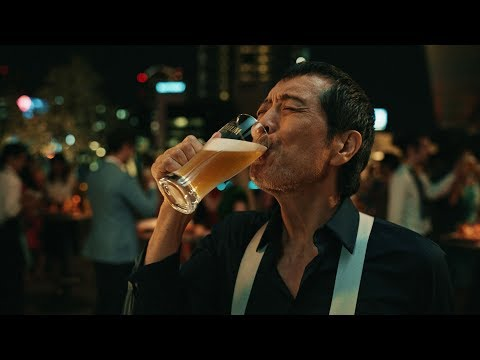

In [9]:
#解析対象動画

import IPython.display

IPython.display.YouTubeVideo('7rHLb80Vfs0')

In [3]:
#モジュールインポート

# TensorFlow and TF-Hub modules.
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

from moviepy.editor import VideoFileClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3325952/45929032 bytes (7.2%)6995968/45929032 bytes (15.2%)10805248/45929032 bytes (23.5%)14483456/45929032 bytes (31.5%)17915904/45929032 bytes (39.0%)21561344/45929032 bytes (46.9%)25051136/45929032 bytes (54.5%)28590080/45929032 bytes (62.2%)32350208/45929032 bytes (70.4%)36069376/45929032 bytes (78.5%)39747584/45929032 bytes (86.5%)43483136/45929032 bytes (94.7%)

In [0]:
#ヘルパー関数

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "http://crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))
        
        
#動画の情報確認
def video_info(video_path):

    cap = cv2.VideoCapture(video_path)

    # 幅
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    # 高さ
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    # 総フレーム数
    count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # fps
    fps = cap.get(cv2.CAP_PROP_FPS)
    # 動画の長さ
    time = count/fps
    print("width:{}, height:{}, count:{}, fps:{:.1f}, seconds:{:.1f}".format(width,height,count,fps,time))
    
    return cap,width,height,count,fps,time

In [5]:
#アクションラベル
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


In [37]:
#アクションラベル例
labels[:10]

['abseiling',
 'air drumming',
 'answering questions',
 'applauding',
 'applying cream',
 'archery',
 'arm wrestling',
 'arranging flowers',
 'assembling computer',
 'auctioning']

In [26]:
#動画の情報を調べる

video_path = "7rHLb80Vfs0mp4"
v_cap, v_width, v_height, v_count, v_fps, v_time = video_info(video_path)

width:1920.0, height:1080.0, count:360.0, fps:24.0, seconds:15.0


In [27]:
#load_video()関数でnumpy形式に変換

sample_video = load_video(video_path)
print("sample_video is a numpy array of shape %s." % str(sample_video.shape))

sample_video is a numpy array of shape (360, 224, 224, 3).


In [28]:
#　動画解析の実行


model_input = np.expand_dims(sample_video, axis=0)


with tf.Graph().as_default():
  i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
  input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
  logits = i3d(input_placeholder)
  probabilities = tf.nn.softmax(logits)
    
  with tf.train.MonitoredSession() as session:
    [ps] = session.run(probabilities,
                       feed_dict={input_placeholder: model_input})

print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
  print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
contact juggling       9.64%
drinking beer          7.23%
drinking               6.28%
tai chi                6.11%
headbutting            5.18%


予測値が一番高い行動はジャグリングでしたが、drinking beer、drinkingもしっかり予測されています


# 場面切り出しからの解析

6秒-9秒のダーツ場面を切り抜く

In [0]:
#切り出した連続動画を保存するディレクトリ
!mkdir vid

In [33]:
#動画の切り出し　　

#編集する動画パス
file_path = video_path 

#切り出し開始秒
start = 6
#切り出し終了秒
end = 9

#編集後のファイル保存先とパス
save_path = "vid/{}-{}.mp4".format(str(start),str(end))


#カット実行
video = VideoFileClip(file_path).subclip(start, end)
#書き込み
video.write_videofile(save_path,fps=v_fps)

[MoviePy] >>>> Building video vid/6-9.mp4
[MoviePy] Writing video vid/6-9.mp4


100%|██████████| 72/72 [00:06<00:00, 10.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vid/6-9.mp4 



In [34]:
#load_video()関数でnumpy形式に変換

sample_video = load_video(save_path)
print("sample_video is a numpy array of shape %s." % str(sample_video.shape))

sample_video is a numpy array of shape (72, 224, 224, 3).


In [35]:
#　動画解析の実行

model_input = np.expand_dims(sample_video, axis=0)

with tf.Graph().as_default():
  i3d = hub.Module("https://tfhub.dev/deepmind/i3d-kinetics-400/1")
  input_placeholder = tf.placeholder(shape=(None, None, 224, 224, 3), dtype=tf.float32)
  logits = i3d(input_placeholder)
  probabilities = tf.nn.softmax(logits)
    
  with tf.train.MonitoredSession() as session:
    [ps] = session.run(probabilities,
                       feed_dict={input_placeholder: model_input})

print("Top 5 actions:")
for i in np.argsort(ps)[::-1][:5]:
  print("%-22s %.2f%%" % (labels[i], ps[i] * 100))

Top 5 actions:
throwing axe           17.62%
shaking hands          7.13%
contact juggling       5.36%
spray painting         3.55%
drinking beer          3.16%


Dartsというアクションラベルが無いため、斧を投げているという解析でした。